# Recommender Systems

In this notebook, we will examine different applications and approaches for Recommender Systems on Movie Rating based datasets. We use Collabrative and Content Based Approach for these datasets. Also we will look at model based approaches and memory based approaches.

**Used Algorithms in This Notebook**:
- Singular Value Decomposition
- Matrix Factorization
- TF-IDF Analysis

**Used Dataset in This Notebook**
- [Used MovieLens Dataset (Kaggle)](https://www.kaggle.com/rounakbanik/the-movies-dataset/data)
- [Latest MovieLens Dataset](https://grouplens.org/datasets/movielens/latest/)

**Used Library in This Notebook**
- [Recompy Library](https://github.com/CanBul/recompy)


## Collaborative Filtering

> With Collaborative Approach, features of users or features of items are not used. This approach only looks at **user-item interaction matrix**. Purpose of this filtering method is finding similar users to recommend items from one to another or finding similar items to recommend one item if the other one interacted by the user.




---


* **MovieLens** Dataset will be used in this section
* **Recompy** Library
* **Matrix Factorization** Algorithm and its usage  
* **Model Based** and **Memory Based** Methods for Collaborative Filtering

### User-Item Matrix

This matrix includes interactions which are given by users to items. Like rating a movie, liking/disliking a book/video. 


---



* First install recompy library

In [1]:
%%capture
!pip install recompy

*    **load_movie_data** function is used for the MovieLens dataset as a dataframe which includes user item interaction pairs.

In [2]:
from recompy import load_movie_data
import pandas as pd

data = load_movie_data()

In [3]:
print(data.shape)
data

(100000, 3)


array([[1.96e+02, 2.42e+02, 3.00e+00],
       [1.86e+02, 3.02e+02, 3.00e+00],
       [2.20e+01, 3.77e+02, 1.00e+00],
       ...,
       [2.76e+02, 1.09e+03, 1.00e+00],
       [1.30e+01, 2.25e+02, 2.00e+00],
       [1.20e+01, 2.03e+02, 3.00e+00]])

* These 3 columns represent user ID, item ID and rating for that item

In [4]:
df_ratings = pd.DataFrame(data, columns = ['userId', 'itemId', 'rating'])

In [5]:
df_ratings.head()

,userId,itemId,rating
0,196.0,242.0,3.0
1,186.0,302.0,3.0
2,22.0,377.0,1.0
3,244.0,51.0,2.0
4,166.0,346.0,1.0


*   Return this dataframe to a **user-item matrix** which has users as columns and items as rows

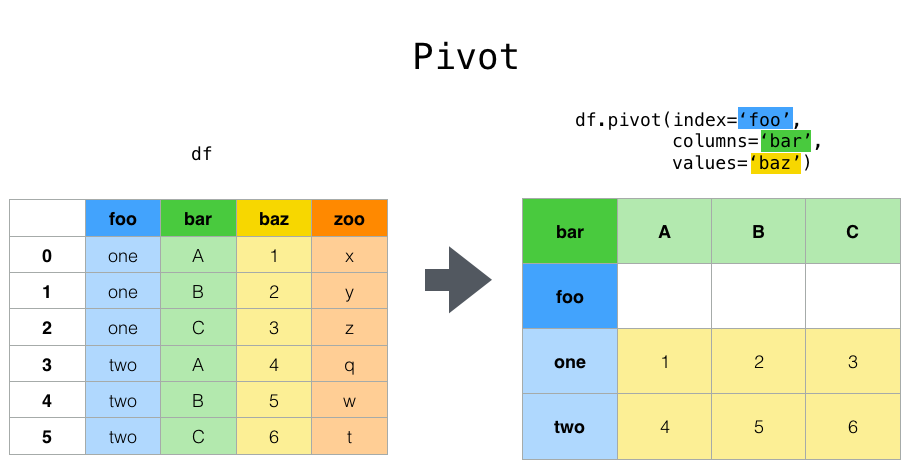

In [6]:
df_ratings_pivot = df_ratings.pivot(index='itemId', columns='userId', values='rating')

In [7]:
df_ratings_pivot

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,...,904.0,905.0,906.0,907.0,908.0,909.0,910.0,911.0,912.0,913.0,914.0,915.0,916.0,917.0,918.0,919.0,920.0,921.0,922.0,923.0,924.0,925.0,926.0,927.0,928.0,929.0,930.0,931.0,932.0,933.0,934.0,935.0,936.0,937.0,938.0,939.0,940.0,941.0,942.0,943.0
itemId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN,1.0,5.0,4.0,5.0,NaN,3.0,5.0,NaN,5.0,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,2.0,NaN,NaN,4.0,3.0,3.0,4.0,NaN,3.0,5.0,3.0,5.0,NaN,NaN,5.0,NaN,3.0,3.0,NaN,4.0,3.0,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
2.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,5.0,5.0,NaN,NaN,5.0,NaN,3.0,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1679.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



> User-Item Matrix is very sparse as you can see. What can we do?


* We can do nothing, keep original matrix and just take intersections while computing similarities.
* NaN values can be filled with **global mean**.
* They can be filled with **user's mean** or **item's mean**.

* 93% of the table has no value

In [8]:
df_ratings_pivot.isna().sum().sum()/(df_ratings_pivot.shape[0]*df_ratings_pivot.shape[1])

0.9369533063577546

* How many movies have watched or rated by an average person?

In [9]:
df_ratings_pivot.isna().sum() # NaN counts of each column/each user

userId
1.0      1410
2.0      1620
3.0      1628
4.0      1658
5.0      1507
         ... 
939.0    1633
940.0    1575
941.0    1660
942.0    1603
943.0    1514
Length: 943, dtype: int64

In [10]:
number_of_items = len(df_ratings_pivot)
number_of_items

1682

In [11]:
(number_of_items - df_ratings_pivot.isna().sum()).mean()

106.04453870625663

* How many people watched or rated a movie for average?

In [12]:
number_of_users = len(df_ratings_pivot.T)
number_of_users

943

In [13]:
(number_of_users - df_ratings_pivot.isna().T.sum()).mean()

59.45303210463734

### Model Based Solution to Collaborative Approach

* FunkSVD class in the library will be used.

* **S**ingular **V**alue **D**ecomposition :
    * Data Reduction
    * Basis PCA (Key Correlations)
    * [Tutorial for SVD](https://www.youtube.com/watch?v=gXbThCXjZFM)

* **FunkSVD :** Funk SVD decomposes a matrix (with missing values) into two components **(U)** and **(V)**. The singular values are folded into these matrices. The approximation for the original matrix can be obtained by **\(R = UV' \)**.


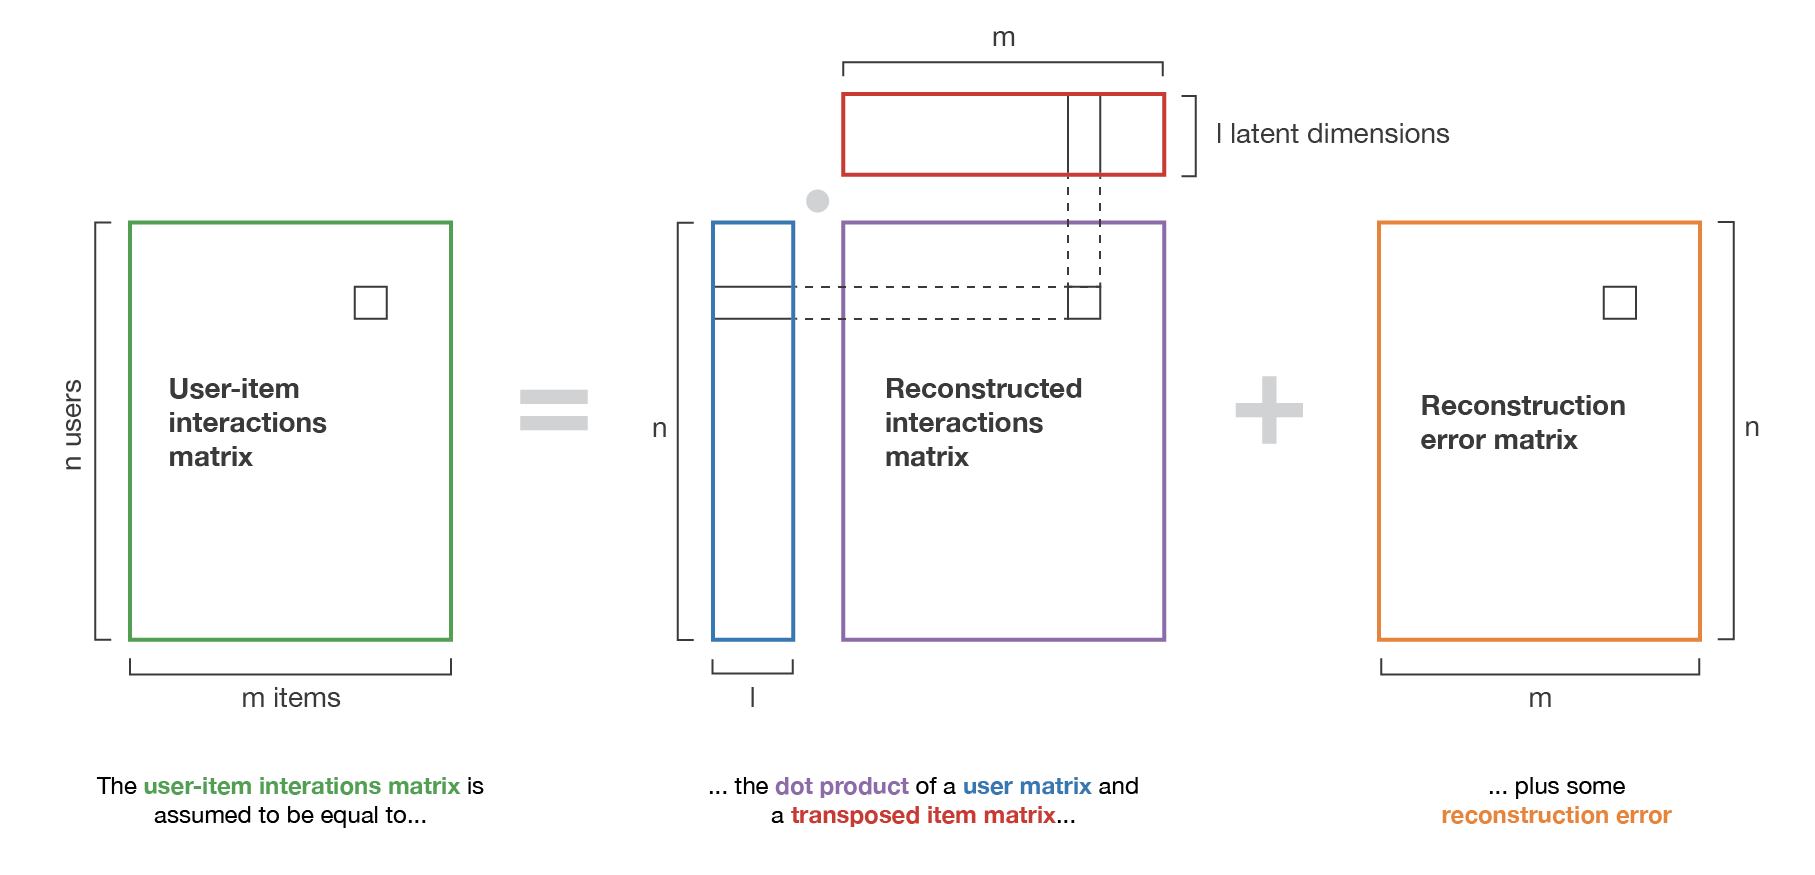

* We do not analyze all class code row by row, but it is important to learn how to multiply matrixes, calculate the error and update the parameters. These are the basic logic of model based approach. 

In [14]:
class FunkSVD():

    def __init__(self):
        # Initialize default hyperparameters
        self.set_hyperparameters()

    def set_hyperparameters(self, initialization_method='random',
                            max_epoch=5, n_latent=10, learning_rate=0.01, 
                            regularization=0.1, early_stopping=False, 
                            init_mean=0, init_std=1):
      
        self.initialization_method = initialization_method
        self.max_epoch = max_epoch
        self.n_latent = n_latent
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.early_stopping = early_stopping
        self.init_mean = init_mean
        self.init_std = init_std

        self.min_train_error = np.inf
        self.min_test_error = np.inf

    # unique users, unique items, train-test split, user informed etc.    
    def __set_data(self, data, test_portion):

        # get distinct users, items and user_existing_ratings, items_existing_users
        self.user_existing_ratings = {}
        self.items_rated_by_users = {}
        self.user_ids = []
        self.item_ids = []

        np.random.shuffle(data)

        # variables for train and test split
        user_dictionary = {}
        item_dictionary = {}
        self.train_data = []
        self.test_data = []

        self.train_data_user_ids = []
        self.train_data_item_ids = []
        self.test_data_user_ids = []
        self.test_data_item_ids = []

        for user, item, score in data:
            # Unique users and items

            try:
                user = int(user)
            except:
                pass
            try:
                item = int(item)
            except:
                pass

            user = str(user)
            item = str(item)
            score = float(score)

            if user not in self.user_existing_ratings:
                self.user_ids.append(user)
            if item not in self.items_rated_by_users:
                self.item_ids.append(item)

            self.items_rated_by_users.setdefault(item, []).append(user)
            self.user_existing_ratings.setdefault(user, []).append(item)

            ratio = len(self.test_data) / (len(self.train_data)+0.001)

            if self.test_split:
                # train and test set
                user_dictionary.setdefault(user, 0)
                item_dictionary.setdefault(item, 0)

                if user_dictionary[user] * test_portion >= 1 and item_dictionary[item] * test_portion >= 1 and ratio <= test_portion+0.02:

                    self.test_data.append([user, item, score])
                    if user not in self.test_data_user_ids: self.test_data_user_ids.append(user)
                    if item not in self.train_data_item_ids: self.test_data_item_ids.append(item)

                    user_dictionary[user] -= 1
                    item_dictionary[item] -= 1

                else:
                    self.train_data.append([user, item, score])
                    if user not in self.train_data_user_ids: self.train_data_user_ids.append(user)
                    if item not in self.train_data_item_ids: self.train_data_item_ids.append(item)

                    user_dictionary[user] += 1
                    item_dictionary[item] += 1
            else:
                self.train_data.append([user, item, score])
                if user not in self.train_data_user_ids: self.train_data_user_ids.append(user)
                if item not in self.train_data_item_ids: self.train_data_item_ids.append(item)

        print('Your data has {} distinct users and {} distinct items.'.format(
            len(self.user_ids), len(self.item_ids)))

        if len(self.test_data) < 1 and self.test_split:
            self.test_split = False
            self.early_stopping = False
            print("Training set doesn't have enough data for given test portion.")

        if self.test_split:

            print('Your data has been split into train and test set.')
            print('Length of training set is {}. Length of Test set is {}'.format(
                len(self.train_data), len(self.test_data)))
        else:

            print('Your data has no test set.')
            print('Length of training set is {}'.format(len(self.train_data)))

    def fit(self, data, test_split=True, test_portion=0.1, search_parameter_space=False):

        # Set train_data, test_data, user_ids etc. if search parameter is False
        # If True, this lets us search parameter space with the same train-test split
        if not search_parameter_space:

            self.test_split = test_split
            self.__set_data(data, test_portion)

        # Initialization
        print('Initializing features for Users and Items...')
        initial = initializer(self.user_ids, self.item_ids, self.initialization_method,
                              self.n_latent, self.init_mean, self.init_std)

        self.user_features, self.item_features = initial.initialize_latent_vectors()

        # Training
        print('Starting training...')
        error_counter = 0
        for epoch in range(self.max_epoch):

            # updating user and item features
            for user, item, rating in self.train_data:

                error = rating - \
                    np.dot(self.user_features[user], self.item_features[item])
                # Use temp to update each item and user feature in sync.
                temp = self.user_features[user]

                # Update user and item feature for each user, item and rating pair
                self.user_features[user] += self.learning_rate * \
                    (error * self.item_features[item] -
                     self.regularization * self.user_features[user])
                self.item_features[item] += self.learning_rate * \
                    (error * temp - self.regularization *
                     self.item_features[item])

            # Calculate errors
            error_counter += 1
            train_error = Test.rmse_error(
                self.train_data, self.user_features, self.item_features)

            # Show error to Client
            if self.test_split:
                test_error = Test.rmse_error(
                    self.test_data, self.user_features, self.item_features)
                print('Epoch Number: {}/{} Training RMSE: {:.2f} Test RMSE: {}'.format(epoch+1, self.max_epoch,
                                                                                       train_error, test_error))

            else:
                print('Epoch Number: {}/{} Training RMSE: {:.2f}'.format(epoch+1, self.max_epoch,
                                                                         train_error))

            # Save best features depending on test_error
            if self.test_split and test_error < self.min_test_error:
                self.min_test_error = test_error
                self.best_user_features = copy.deepcopy(self.user_features)
                self.best_item_features = copy.deepcopy(self.item_features)

                error_counter = 0
            # Save best features if test data is False
            elif not self.test_split and train_error < self.min_train_error:
                self.min_train_error = train_error
                self.best_user_features = copy.deepcopy(self.user_features)
                self.best_item_features = copy.deepcopy(self.item_features)

            # Break if test_error didn't improve for the last n rounds and early stopping is true
            if self.early_stopping and error_counter >= self.early_stopping:

                print("Test error didn't get lower for the last {} epochs. Training is stopped.".format(
                    error_counter))
                print('Best test error is: {:.2f}. Best features are saved.'.format(
                    self.min_test_error))
                break

        print('Training has ended...')
        self.user_features = copy.deepcopy(self.best_user_features)
        self.item_features = copy.deepcopy(self.best_item_features)

    def get_recommendation_for_existing_user(self, user_id, howMany=10):
        result_list = []
        # this might be more effective using matrix multiplication
        for item in self.item_ids:
            # if user did not already rate the item
            if item not in self.user_existing_ratings[user_id]:
                prediction = np.dot(
                    self.user_features[user_id], self.item_features[item])
                bisect.insort(result_list, [prediction, item])

        return [x[1] for x in result_list[::-1][0:howMany]]

    def get_recommendation_for_new_user(self, user_ratings,
                                        similarity_measure='mean_squared_difference', howManyUsers=3, howManyItems=5):

        # Get user predictions on same movies
        user_predictions = self.__user_prediction_for_same_movies(user_ratings)
        # Find most most similar user_ids
        user_ids = Similarities.get_most_similar_users(
            user_ratings, user_predictions, similarity_measure, howManyUsers)

        result_list = []
        # get user features for users who are most similar to given new user
        for user in user_ids:
            for item, item_feature in self.item_features.items():
                # predict ratings for most similar users
                prediction = np.dot(
                    self.user_features[user], item_feature)
                bisect.insort(result_list, [prediction, item])

        # remove duplicates
        return_list = []
        for pair in result_list:
            if len(return_list) >= howManyItems:
                break
            if pair[1] in return_list:
                continue

            return_list.append(pair[1])

        return return_list

    def get_similar_products(self, item_id, howMany=10):

        result_list = []
        product_features = self.item_features[item_id]

        for item in self.item_ids:

            if item == item_id:
                continue
            # add cosine sim function from similarites
            cos_sim = Similarities.cosine_similarity(
                self.item_features[item], product_features)

            bisect.insort(result_list, [cos_sim, item])

        return [x[1] for x in result_list[::-1][0:howMany]]

    def __user_prediction_for_same_movies(self, user_ratings):
        result = {}
        for key in user_ratings:
            if key not in self.item_features:
                continue

            for user in self.user_features:
                result.setdefault(user, []).append(
                    np.dot(self.user_features[user], self.item_features[key]))

        return result

### Training

In [15]:
from recompy import load_movie_data, FunkSVD

In [16]:
data = load_movie_data()

In [17]:
myFunk = FunkSVD()

In [18]:
myFunk.set_hyperparameters(max_epoch=100, n_latent=20,early_stopping=True, initialization_method='random', regularization=0.1)

In [19]:
myFunk.fit(data)

Your data has 943 distinct users and 1682 distinct items.
Your data has been split into train and test set.
Length of training set is 89285. Length of Test set is 10715
Initializing features for Users and Items...
Starting training...
Epoch Number: 1/100 Training RMSE: 0.98 Test RMSE: 0.9955076190888459
Epoch Number: 2/100 Training RMSE: 0.93 Test RMSE: 0.9694057912398261
Epoch Number: 3/100 Training RMSE: 0.92 Test RMSE: 0.9612010728881564
Epoch Number: 4/100 Training RMSE: 0.91 Test RMSE: 0.9573001916341444
Epoch Number: 5/100 Training RMSE: 0.90 Test RMSE: 0.9548422538591608
Epoch Number: 6/100 Training RMSE: 0.90 Test RMSE: 0.9529286995001772
Epoch Number: 7/100 Training RMSE: 0.89 Test RMSE: 0.9511800251172953
Epoch Number: 8/100 Training RMSE: 0.89 Test RMSE: 0.9493900899963431
Epoch Number: 9/100 Training RMSE: 0.89 Test RMSE: 0.9474295322479472
Epoch Number: 10/100 Training RMSE: 0.88 Test RMSE: 0.9452231308615645
Epoch Number: 11/100 Training RMSE: 0.88 Test RMSE: 0.9427521699

### Evaluation Part

* Define a new user with some interactions to some items.
* Use the model for getting recommendation
* It recommends by finding most **similar user** to the new user and recommend items from that user to the new one.

In [20]:
new_user = {'1':5,
            '2':4,
            '4':3}

In [21]:
myFunk.get_recommendation_for_new_user(new_user, 
                                       similarity_measure = 'cosine_similarity', 
                                       howManyUsers = 1, 
                                       howManyItems = 5)

['437', '1386', '314', '1420', '834']

* You can try also other methods of the model like **get_similar_products, get_recommendation_for_existing_user** etc.

## Content Based Filtering


> With Content Based Approach, **contents of the items** and **features of the users** can be included beside user-item interaction matrix while getting recommendations. 

* Item-Centered Models : Uses user features as content
* User-Centered Models : Uses item features as content
* Hybrid Models        : Uses both user and item features


---

* [Kaggle MovieLens Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset/data) will be used in this section. 

---




* Mount Drive first

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Files in Dataset:**
  * _movies_metadata_ : Features belong to movies (~45k)
  * _keywords_ : Keywords extracted from plot of the movies
  * _credits_ : Cast and crew information
  * _links_ : TMDB and IMDB IDs of all movies
  * _ratings_ : User-Movie interactions

---



  

* Import libraries

In [23]:
import pandas as pd
from numpy import dot
from numpy.linalg import norm
import numpy as np

* Read the metadata file

In [24]:
metadata = pd.read_csv('/content/drive/MyDrive/applied_ai_enes_safak/recommender_systems/MovieLens/movies_metadata.csv', low_memory=False)

* Fill NaN overviews with empty string

In [25]:
metadata['overview'] = metadata['overview'].fillna('')

### Scoring with Weighted Ratings

* Ratings of movies are not always reliable because of number of voters. If one movie with a 1000 votes has 4.7 rating score and another one is 5 rating score with 50 votes, first one is more reliable for analyzes.
 

---
\begin{equation}
\text Weighted Rating (\bf WR) = \left({{\bf v} \over {\bf v} + {\bf m}} \cdot R\right) + \left({{\bf m} \over {\bf v} + {\bf m}} \cdot C\right)
\end{equation}

---

* **v** is the number of votes for the movie;

* **m** is the minimum votes required to be listed in the chart;

* **R** is the average rating of the movie;

* **C** is the mean vote across the whole report.

---



* Average rating of a movie on IMDB is around 5.6 on a scale of 10

In [26]:
C = metadata['vote_average'].mean()
C

5.618207215133889

* Only %10 of all movies rated more than 160 times

In [27]:
(metadata['vote_count'] > 160).value_counts()

False    40928
True      4538
Name: vote_count, dtype: int64

In [28]:
4538 / len(metadata)

0.09981084766638806

In [29]:
metadata['vote_count']

0        5415.0
1        2413.0
2          92.0
3          34.0
4         173.0
          ...  
45461       1.0
45462       3.0
45463       6.0
45464       0.0
45465       0.0
Name: vote_count, Length: 45466, dtype: float64

In [30]:
m = metadata['vote_count'].quantile(0.9)
m

160.0

In [31]:
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
print(q_movies.shape)
print(metadata.shape)

(4555, 24)
(45466, 24)


In [32]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [33]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

### Sort by Score

* IMDb vs Scoring Function

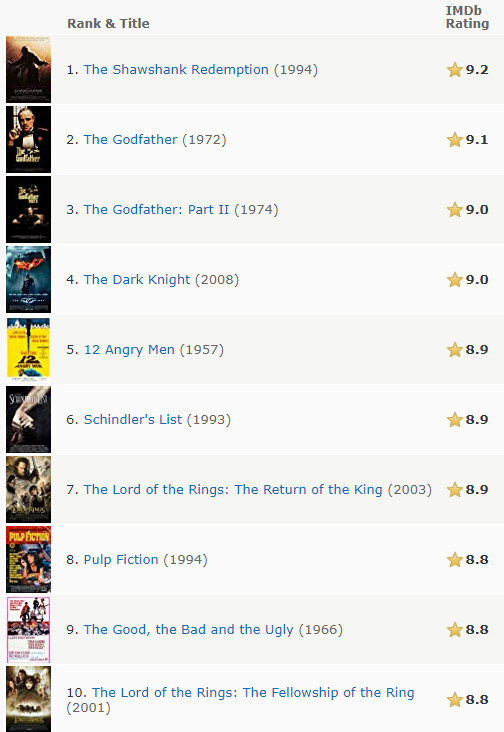

In [34]:
q_movies = q_movies.sort_values('score', ascending=False)

q_movies[['title', 'vote_count', 'vote_average', 'score']].head(20).reset_index(drop=True)

,title,vote_count,vote_average,score
0,The Shawshank Redemption,8358.0,8.5,8.445869
1,The Godfather,6024.0,8.5,8.425439
2,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
3,The Dark Knight,12269.0,8.3,8.265477
4,Fight Club,9678.0,8.3,8.256385
5,Pulp Fiction,8670.0,8.3,8.251406
6,Schindler's List,4436.0,8.3,8.206639
7,Whiplash,4376.0,8.3,8.205404
8,Spirited Away,3968.0,8.3,8.196055
9,Life Is Beautiful,3643.0,8.3,8.187171


### **Overview** is the Content

#### With **Term Frequency-Inverse Document Frequency (TF-IDF)** Analysis

* TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates **how relevant a word is** to a document in a collection of documents.

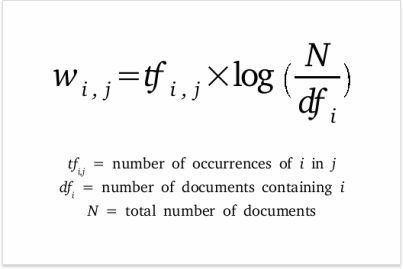

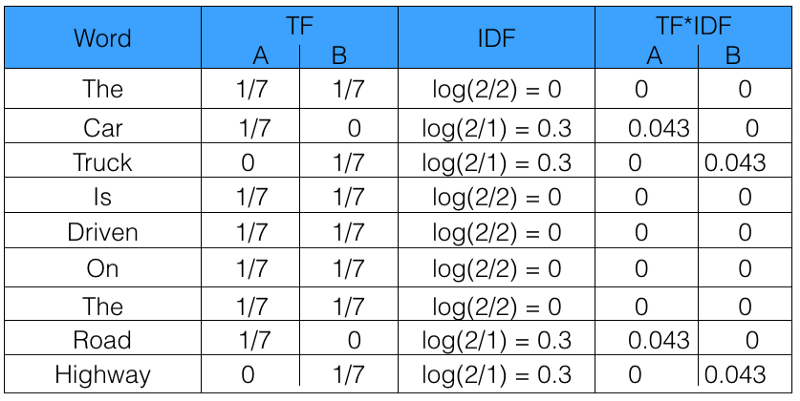

In [35]:
pd.DataFrame(metadata[['original_title','overview']].head())

,original_title,overview
0,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...


In [36]:
m = metadata['vote_count'].quantile(0.9)
metadata_small = metadata.copy().loc[metadata['vote_count'] >= m]

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

* 19694 different words in overview for 4555 Movies

In [38]:
tfidf_matrix = tfidf.fit_transform(metadata_small['overview'])

tfidf_matrix.shape

(4555, 19694)

* Each row represents a movie overview as TF-IDF Vector with the length of unique number of words in overview column.

In [39]:
tfidf_matrix

<4555x19694 sparse matrix of type '<class 'numpy.float64'>'
	with 115437 stored elements in Compressed Sparse Row format>

* **Similarity Score :** Cosine Similarity will be used. 

In [40]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [41]:
cosine_sim.shape

(4555, 4555)

In [42]:
cosine_sim[0][0]

1.0

* Construct a serie for mapping movies and IDs  

In [43]:
indices = pd.Series(metadata_small.index, index=metadata_small['title']).drop_duplicates()

In [44]:
for i in range(len(indices)):
  indices[i] = i

In [45]:
indices

title
Toy Story                         0
Jumanji                           1
Father of the Bride Part II       2
Heat                              3
Sudden Death                      4
                               ... 
Brice 3                        4550
Girls Trip                     4551
Descendants 2                  4552
Force Majeure                  4553
The Visitors: Bastille Day     4554
Length: 4555, dtype: int64

* **get_recommendations :** 
  * Takes title and similarity matrix as input parameters
  * Returns k most similar movies as recommendations

In [46]:
def get_recommendations(title, cosine_sim, k):
  
    idx = indices[title] # get the index of title
    sim_scores = list(enumerate(cosine_sim[idx])) # get that movies similarities with other movies 
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # sort that list
    sim_scores = sim_scores[1:(k+1)] # get first k element 
    movie_indices = [i[0] for i in sim_scores] # get similar movies indexes

    return pd.DataFrame(metadata_small['title'].iloc[movie_indices]).reset_index(drop=True) # return the titles with looking at metadata dataframe

In [47]:
get_recommendations("Inglourious Basterds", cosine_sim, 5)

,title
0,Black Book
1,Don't Look Now: We're Being Shot At
2,Kelly's Heroes
3,Schindler's List
4,Defiance


In [48]:
get_recommendations('Django Unchained', cosine_sim, 5) # kesin izleyin...

,title
0,One for the Money
1,Mud
2,Domino
3,Hot Shots! Part Deux
4,Life


In [49]:
get_recommendations('There Will Be Blood', cosine_sim, 5) # kesin izleyin...

,title
0,The World Is Not Enough
1,The Abyss
2,Harry Potter and the Half-Blood Prince
3,Pale Rider
4,Far and Away


#### Recommendation with Overview Vectors

* Use overviews as content but this time, get the overview's vectors with using word model.

* Use these vectors to find similarity between movies

---




* Imports

In [50]:
import pandas as pd
import re
import numpy as np
import string
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import string
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from keras.preprocessing.text import Tokenizer
import scipy.stats

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


* Read the data again

In [51]:
metadata = pd.read_csv('/content/drive/MyDrive/applied_ai_enes_safak/recommender_systems/MovieLens/movies_metadata.csv', low_memory=False)
len(metadata)

45466

In [52]:
pd.DataFrame(metadata[['original_title','overview']].head(10))

,original_title,overview
0,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...
5,Heat,"Obsessive master thief, Neil McCauley leads a ..."
6,Sabrina,An ugly duckling having undergone a remarkable...
7,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses..."
8,Sudden Death,International action superstar Jean Claude Van...
9,GoldenEye,James Bond must unmask the mysterious head of ...


In [53]:
metadata['overview'].isna().sum()

954

* Drop empty rows

In [54]:
metadata = metadata[metadata['overview'].isna() == False]

In [55]:
metadata['overview'].isna().sum()

0

In [56]:
len(metadata)

44512

* Create a Word2Vec model from GloVe vectors

In [ ]:
'''
glove_file = 'gloVe_eng.txt'
word2vec_file = "Word2Vec_eng.txt"

glove2word2vec(glove_file, word2vec_file)
model = KeyedVectors.load_word2vec_format(word2vec_file)
'''

* Load saved word model

In [58]:
import pickle
filename = '/content/drive/MyDrive/applied_ai_enes_safak/recommender_systems/Word2Vec_model_eng.pkl'
model = pickle.load(open(filename, 'rb'))

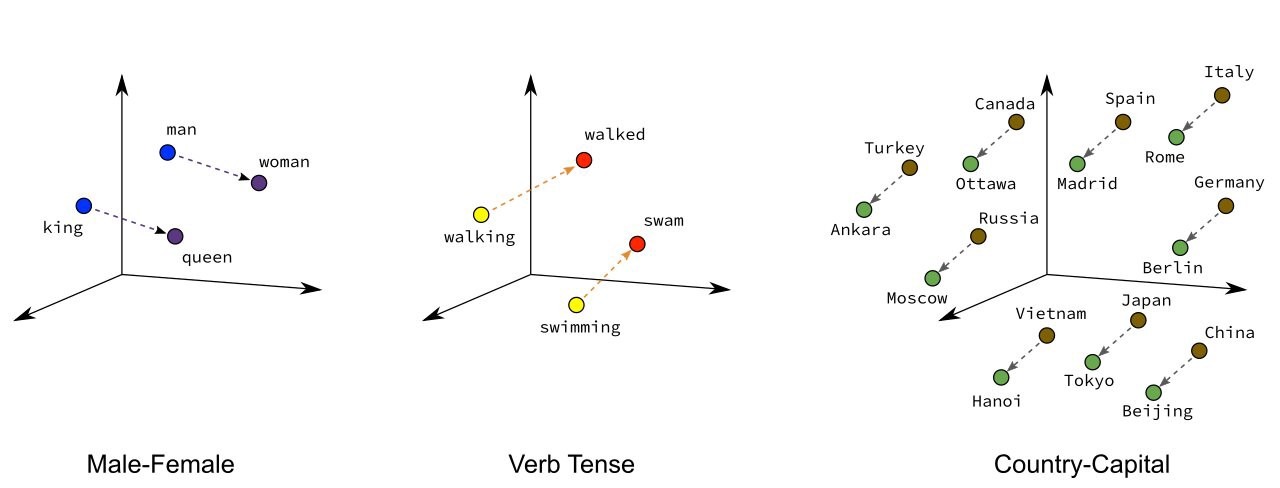

In [59]:
model.most_similar('cat')

[('cats', 0.7989761829376221),
 ('dog', 0.7885448932647705),
 ('kitten', 0.7550500631332397),
 ('pet', 0.7330316305160522),
 ('kitty', 0.6883490085601807),
 ('dogs', 0.6766945123672485),
 ('puppy', 0.6289974451065063),
 ('animal', 0.6256890296936035),
 ('kittens', 0.6217527985572815),
 ('pets', 0.609766960144043)]

* Each word represents with 300 dimentional vector

In [60]:
len(model.get_vector('cat'))

300

* **Bag of Words** is used for finding unique words in the overviews



> The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. The bag-of-words model has also been used for computer vision. (Wikipedia: bag of words)



In [61]:
def find_bow(sentence):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentence)
    sequences = tokenizer.texts_to_sequences(sentence)
    word_index = tokenizer.word_index 
    bow = {}
    for key in word_index:
        bow[key] = sequences[0].count(word_index[key])

    return bow, len(word_index)

* A fucntion for removing all punctuations from texts

In [62]:
import string

def remove_punctuation(text):
  PUNCT_TO_REMOVE = string.punctuation
  return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [63]:
metadata['overview'] = metadata['overview'].apply(lambda text: remove_punctuation(text))

* Remove the stopwords like a, an, the, because etc. from text

In [64]:
docs = metadata['overview']
docs_list = []

WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('english')

for doc in docs:
    doc = re.sub("\d+"," ",doc) # remove numbers
    doc = WPT.tokenize(doc)
    filtered_tokens = [item for item in doc if item not in stop_word_list]
    lemma = nltk.WordNetLemmatizer()
    lemma_word = [lemma.lemmatize(word) for word in filtered_tokens]

    doc = " ".join(lemma_word)

    docs_list.append(doc)

metadata['overview'] = pd.DataFrame(docs_list, columns=['overview'])

* Remove null and empty rows again

In [65]:
metadata['overview'].isna().sum()

914

In [66]:
metadata = metadata[metadata['overview'].isna() == False]

In [67]:
(metadata['overview'] != '').value_counts()

True     43592
False        6
Name: overview, dtype: int64

In [68]:
metadata = metadata[metadata['overview'] != '']

In [69]:
metadata['overview'].isna().sum()

0

In [70]:
(metadata['overview'] != '').value_counts()

True    43592
Name: overview, dtype: int64

In [71]:
metadata['vectors'] = [np.zeros(300) for i in range(len(metadata))]
not_found = 0
for i,text in enumerate(metadata['overview']):
  bow, count = find_bow([text])
  word_list = list(bow.keys()) # finding bag of words for a sample
  avg_vector = np.zeros(300) 
  for word in word_list:
    try:
      avg_vector += model.get_vector(word) # finding vectors of these words
      count += 1
    except:
      not_found += 1
  if count != 0:
    metadata['vectors'][i] = avg_vector/count # taking average of all words in bag of words for this sample 

print("Average words which are not found in sentences : " + str(not_found/len(metadata)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Average words which are not found in sentences : 0.5084877959258579


In [72]:
metadata = metadata.reset_index(drop=True)

* Drop zero vectors from overviews

In [73]:
drop_list = []
[drop_list.append(k) for k,i in enumerate(metadata['vectors']) if i.sum() == 0]
print("Dropped lines after vectorization: " + str(len(drop_list)))
metadata = metadata.drop(drop_list).reset_index(drop=True)
print("Number of remaining samples: " + str(len(metadata))) 

Dropped lines after vectorization: 882
Number of remaining samples: 42710


* Euclidean distance for getting distance of overview vectors

In [74]:
def euclidean(arr1, arr2):
  return np.sqrt(((arr1 - arr2)**2).sum())

* Takes the movie title, metadata dataframe and number of movied which will be recommended as parameters.

* Find the movie's distances with all movies and take the first n movie for recommendation

In [75]:
def closest_n(movie, metadata, n):
  distances = np.zeros((len(metadata)))
  
  if len(metadata[metadata['title'] == movie]) == 0:
    print("This movie is not in the dataset...")
    return

  ind = metadata[metadata['title'] == movie].index[0]

  k = 0
  for i in range(len(metadata)):
    distances[k] = (euclidean(metadata['vectors'][ind], metadata['vectors'][i]))
    k += 1


  closest = np.argsort(distances)

  closest_labels = [metadata['title'][i] for i in closest[1:n+1]]

  return pd.DataFrame(closest_labels, columns=['Movie'])

In [76]:
closest_n('Toy Story', metadata, 10)

,Movie
0,Frisky
1,Brink!
2,Mega Piranha
3,Western
4,Hellevator
5,Greyfriars Bobby: The True Story of a Dog
6,The Kill Hole
7,The Great Global Warming Swindle
8,Parasite Dolls
9,Times of Joy and Sorrow


In [77]:
closest_n('The Dark Knight', metadata, 10)

,Movie
0,Chain Lightning
1,Haunted Castle
2,The Lost World
3,Sublime
4,Haunter
5,Hush!
6,The Outsiders
7,The Extraordinary Adventures of Adèle Blanc-Sec
8,Corridors of Blood
9,Interrupted Melody


## Homework

* Design a recommendation system with using cast of the movies and get recommendation from your system. (COULD BE CHANGED)